In [1]:


import matplotlib.pyplot as plt
import numpy as np#second_q.

from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper


from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [12]:
pip install 'qiskit[nature]'

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 699.9 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 396.6 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 469.8 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 516.3 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 650.9 kB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 366.7 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 511.4 kB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: qiskit-nature
    Found existing installation: qiskit-nature 0.5.2
    Uninstalling qiskit-nature-0.5.2:
      Successfully uninstalled qiskit-nature-0.5.2
Note: you may need to restart the kernel t

In [2]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True,
                               remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [4]:
def exact_solver(problem , converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter,solver) #converter,
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,problem, converter) = get_qubit_op(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,num_particles,num_spin_orbitals,initial_state=init_state)#converter,
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.04751 Exact Energy: -7.04791
Interatomic Distance: 0.6 VQE Result: -7.31769 Exact Energy: -7.31784
Interatomic Distance: 0.7 VQE Result: -7.50392 Exact Energy: -7.50400
Interatomic Distance: 0.8 VQE Result: -7.63332 Exact Energy: -7.63338
Interatomic Distance: 0.9 VQE Result: -7.72278 Exact Energy: -7.72283
Interatomic Distance: 1.0 VQE Result: -7.78398 Exact Energy: -7.78402
Interatomic Distance: 1.1 VQE Result: -7.82516 Exact Energy: -7.82520
Interatomic Distance: 1.2 VQE Result: -7.85212 Exact Energy: -7.85216
Interatomic Distance: 1.3 VQE Result: -7.86886 Exact Energy: -7.86890
Interatomic Distance: 1.4 VQE Result: -7.87819 Exact Energy: -7.87823
Interatomic Distance: 1.5 VQE Result: -7.88210 Exact Energy: -7.88214
Interatomic Distance: 1.6 VQE Result: -7.88206 Exact Energy: -7.88210
Interatomic Distance: 1.7 VQE Result: -7.87917 Exact Energy: -7.87920
Interatomic Distance: 1.8 VQE Result: -7.87417 Exact Energy: -7.87428
Interatomic Distance

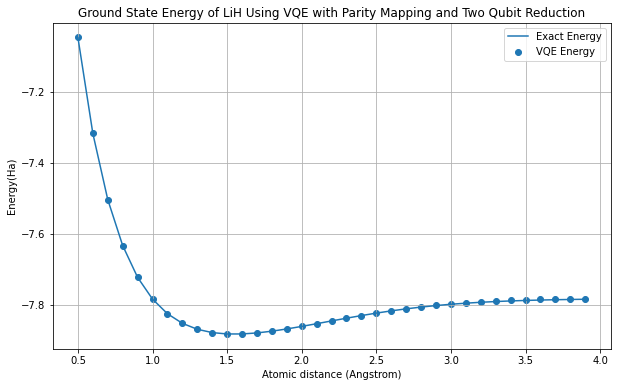

In [9]:
plt.figure(1,figsize=(10,6))
plt.plot(distances, exact_energies, label="Exact Energy")
plt.scatter(distances, vqe_energies, label="VQE Energy")
plt.title("Ground State Energy of LiH Using VQE with Parity Mapping and Two Qubit Reduction")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy(Ha)')
plt.legend()
plt.grid()
plt.savefig('VQE2.png',dpi=500)